In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import mapply
mapply.init(n_workers=7, progressbar=True)

import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean3.csv')

final.columns






/home/stefano/Desktop/Big Data Unipi/DM/Project/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['date_year', 'date_month', 'state', 'incident_characteristics1',
       'congressional_district', 'date_day', 'city_or_county', 'latitude',
       'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'CLEAN', 'timestamp',
       'povertyPercentage', 'party', 'candidatevotes', 'totalvotes',
       'state_population', 'OUTLIER', 'p_males', 'p_females',
       'p_participants_child', 'p_participants_teen', 'p_participants_adult',
       'p_killed', 'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants',
       'month_state_change_min_age_participants',
       'month_state_change_avg_age_participants',
       'month_state_change_max_age_partici

In [2]:
final.shape

final.head()

,date_year,date_month,state,incident_characteristics1,congressional_district,date_day,city_or_county,latitude,longitude,min_age_participants,...,cd_month_SHOT_DEAD,cd_month_NON_SHOOTING,cd_month_SHOTS_FIRED_UNHARMED,cd_month_OTHER,state_month_SHOT_INJURED,state_month_SHOT_DEAD,state_month_NON_SHOOTING,state_month_SHOTS_FIRED_UNHARMED,state_month_OTHER,non_workday
0,2013.0,1,CALIFORNIA,SHOT_INJURED,43.0,1,Hawthorne,33.9090,-118.3330,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,2013.0,1,COLORADO,SHOT_DEAD,6.0,5,Aurora,39.6518,-104.8020,29.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2013.0,1,LOUISIANA,SHOT_INJURED,2.0,21,New Orleans,29.9435,-90.0836,16.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,2013.0,1,LOUISIANA,SHOT_INJURED,3.0,26,Charenton,29.8816,-91.5251,48.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2013.0,1,MARYLAND,SHOT_INJURED,7.0,23,Baltimore,39.2899,-76.6412,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [3]:
#filter only for accidents  between 2014 and 2017
final_wout_wrng_years = final[(final['date_year'] >= 2014) & (final['date_year'] <= 2017)].copy()


## Dataframe with only the correct years for timeseries
final_wout_wrng_years.shape

final_wout_wrng_years.columns

# make a new column with the week number from timestamp//7 - number of weeks from 2010-01-01

final_wout_wrng_years['week_number'] = (final_wout_wrng_years['timestamp']//7) - 208
final_wout_wrng_years['week_number'] = final_wout_wrng_years['week_number'].astype(int)




In [4]:
#sort by week using date_year, date_month, date_day
city_df = final_wout_wrng_years.sort_values(by=['week_number']).copy()
city_df

#boston = city_df[city_df['city_or_county'] == 'Boston'].copy()



#create a new dataframe with 3 colums: week_number, city, number of accidents per week

cool_df = city_df.groupby(['week_number', 'city_or_county']).size().reset_index(name='counts')
#cool_df

#pivot the table to have the cities as columns
pivot_df = cool_df.pivot(index='week_number', columns='city_or_county', values='counts')
#pivot_df

#fill the NaN values with 0
pivot_df = pivot_df.fillna(0)
pivot_df

#make them integers
pivot_df = pivot_df.astype(int)
pivot_df




city_or_county,Abbeville,Abbotsford,Abbott,Abbott Township,Abbottstown,Abercrombie,Aberdeen,Abilene,Abingdon,Abington,...,Zion,Zion (Beach Park),Zion Grove,Zionsville,Zionville,Zumbro Falls,Zumbrota,Zuni (Zuni Pueblo),Zwolle,jefferson parish (county)
week_number,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#remove the colums with less than 15% of 208 weeks
pivot_df = pivot_df.loc[:, (pivot_df.sum(axis=0) > 30)]
pivot_df

#give me the list of cities remaining
pivot_df.columns



final_pivot = pivot_df.copy()

#remove from city_df the cities that are not in the pivot_df
clean_city_df = city_df[city_df['city_or_county'].isin(final_pivot.columns)].copy()

clean_city_df.columns


Index(['date_year', 'date_month', 'state', 'incident_characteristics1',
       'congressional_district', 'date_day', 'city_or_county', 'latitude',
       'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'CLEAN', 'timestamp',
       'povertyPercentage', 'party', 'candidatevotes', 'totalvotes',
       'state_population', 'OUTLIER', 'p_males', 'p_females',
       'p_participants_child', 'p_participants_teen', 'p_participants_adult',
       'p_killed', 'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants',
       'month_state_change_min_age_participants',
       'month_state_change_avg_age_participants',
       'month_state_change_max_age_partici

## Score for each city

In [98]:
TO_RENAME = clean_city_df.copy()

TO_RENAME = TO_RENAME.set_index(['week_number','city_or_county'])

def score(df: pd.DataFrame):
    #return df['n_killed'].sum() + df['n_injured'].sum() * 0.8 + df['n_arrested'].sum() * 0.5 + df['n_participants_child'].sum() * 1 + df['n_participants_teen'].sum() * 0.8 + df['n_participants_adult'].sum() * 0.5
    return df['n_killed'].sum()

TO_RENAME['score'] = TO_RENAME.groupby(TO_RENAME.index.names).apply(score)


score_pivot = TO_RENAME.pivot_table(index='week_number', columns='city_or_county', values='score')
score_pivot = score_pivot.fillna(0)






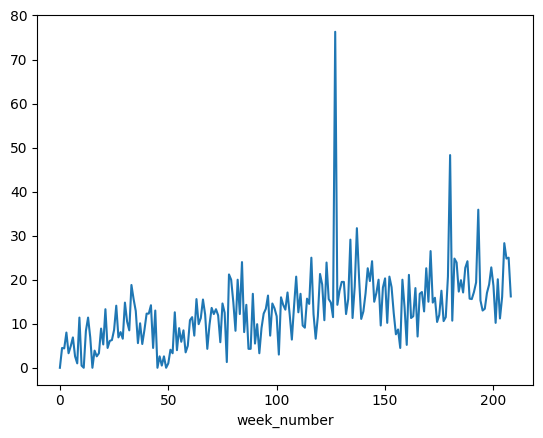

In [7]:
#plot Honolulu
score_pivot['Boston'].plot()
plt.show()



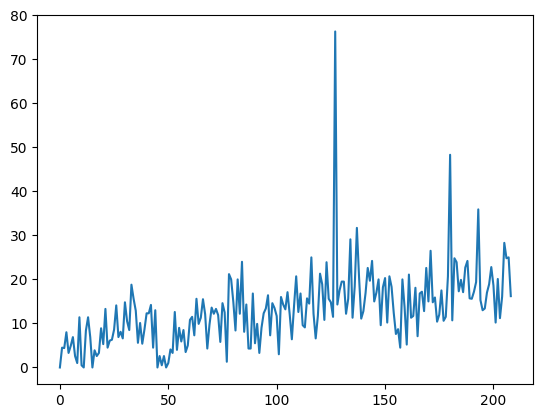

In [8]:
ts1 = pd.Series(score_pivot['Boston'])
plt.plot(ts1)
plt.show()

## Distances between time series 

<Axes: xlabel='week_number'>

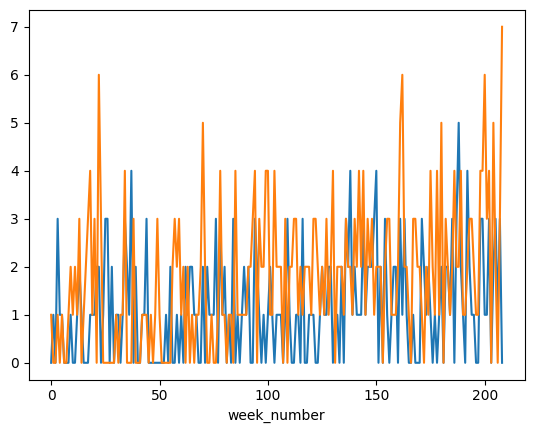

In [99]:
#create a dict containing the cities and the time series for the city
ts_dict = {}
for city in score_pivot.columns:
    ts_dict[city] = pd.Series(score_pivot[city])

ts_dict['Boston'].plot()
ts_dict['Birmingham'].plot()

   

    


In [100]:
#scaler mean variance
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

#------------------------------------------------------------------------------------------
#scaled with mean variance

scaler_mean = TimeSeriesScalerMeanVariance(mu=0, std=1)  

#scale all the time series
scaled_mean_ts_dict = {}
for city in ts_dict.keys():
    scaled_mean_ts_dict[city] = scaler_mean.fit_transform(ts_dict[city].values.reshape(1, -1)).flatten()

#plt.plot(scaled_mean_ts_dict['Boston'])
#plt.plot(scaled_mean_ts_dict['Birmingham'])


#------------------------------------------------------------------------------------------
#scaled with min max

from tslearn.preprocessing import TimeSeriesScalerMinMax

scaler_minmax = TimeSeriesScalerMinMax(value_range=(0, 1))

#scale all the time series
scaled_minmax_ts_dict = {}
for city in ts_dict.keys():
    scaled_minmax_ts_dict[city] = scaler_minmax.fit_transform(ts_dict[city].values.reshape(1, -1)).flatten()

# plt.plot(scaled_minmax_ts_dict['Boston'])
# plt.plot(scaled_minmax_ts_dict['Birmingham'])





In [109]:
from scipy.spatial.distance import euclidean, cityblock

#make the euclidean distance matrix
euclidean_matrix = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(ts_dict.keys()):
    for j, city2 in enumerate(ts_dict.keys()):
        euclidean_matrix[i, j] = euclidean(ts_dict[city1], ts_dict[city2])



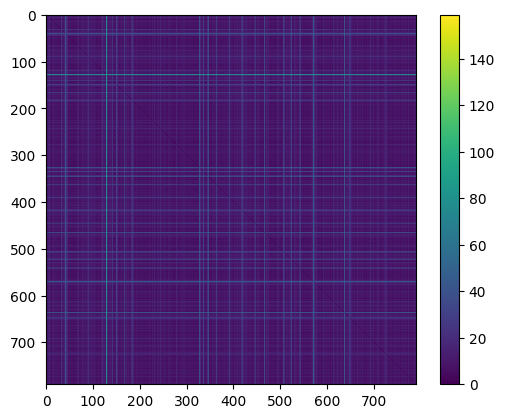

In [110]:
#plot the euclidean distance matrix
plt.imshow(euclidean_matrix)
plt.colorbar()
plt.show()



In [111]:
#make the cityblock distance matrix
cityblock_matrix = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(ts_dict.keys()):
    for j, city2 in enumerate(ts_dict.keys()):
        cityblock_matrix[i, j] = cityblock(ts_dict[city1], ts_dict[city2])

    

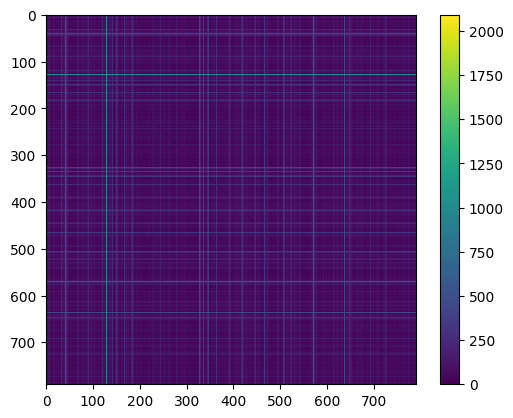

In [112]:
#plot the cityblock distance matrix
plt.imshow(cityblock_matrix)
plt.colorbar()
plt.show()


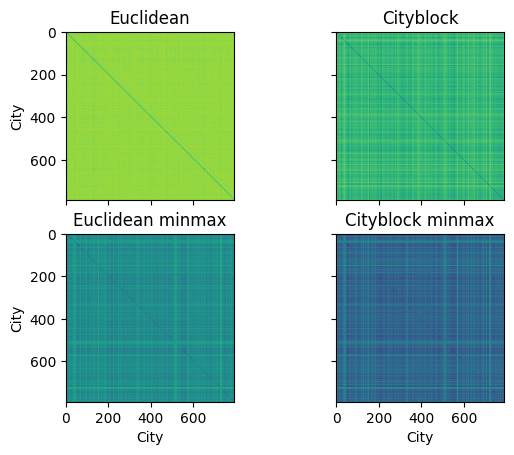

In [27]:
#make the euclidean distance matrix with the scaled time series
euclidean_matrix_scaled = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_mean_ts_dict.keys()):
    for j, city2 in enumerate(scaled_mean_ts_dict.keys()):
        euclidean_matrix_scaled[i, j] = euclidean(scaled_mean_ts_dict[city1], scaled_mean_ts_dict[city2])

#make the cityblock distance matrix with the scaled time series
cityblock_matrix_scaled = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_mean_ts_dict.keys()):
    for j, city2 in enumerate(scaled_mean_ts_dict.keys()):
        cityblock_matrix_scaled[i, j] = cityblock(scaled_mean_ts_dict[city1], scaled_mean_ts_dict[city2])


#make the euclidean distance matrix with the scaled time series
euclidean_matrix_scaled_minmax = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_minmax_ts_dict.keys()):
    for j, city2 in enumerate(scaled_minmax_ts_dict.keys()):
        euclidean_matrix_scaled_minmax[i, j] = euclidean(scaled_minmax_ts_dict[city1], scaled_minmax_ts_dict[city2])

#make the cityblock distance matrix with the scaled time series
cityblock_matrix_scaled_minmax = np.zeros((len(ts_dict), len(ts_dict)))
for i, city1 in enumerate(scaled_minmax_ts_dict.keys()):
    for j, city2 in enumerate(scaled_minmax_ts_dict.keys()):
        cityblock_matrix_scaled_minmax[i, j] = cityblock(scaled_minmax_ts_dict[city1], scaled_minmax_ts_dict[city2])

#plot all the distance matrices with labels
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(euclidean_matrix_scaled)
axs[0, 0].set_title('Euclidean')
axs[0, 1].imshow(cityblock_matrix_scaled)
axs[0, 1].set_title('Cityblock')
axs[1, 0].imshow(euclidean_matrix_scaled_minmax)
axs[1, 0].set_title('Euclidean minmax')
axs[1, 1].imshow(cityblock_matrix_scaled_minmax)
axs[1, 1].set_title('Cityblock minmax')
for ax in axs.flat:
    ax.set(xlabel='City', ylabel='City')
for ax in axs.flat:
    ax.label_outer()
plt.show()



In [101]:
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

dist = dtw(ts_dict['Boston'], ts_dict['Birmingham'])

path, dist = dtw_path(ts_dict['Boston'], ts_dict['Birmingham'])
dist



14.52583904633395

In [102]:
path


[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 1),
 (7, 1),
 (8, 2),
 (9, 3),
 (10, 4),
 (11, 4),
 (12, 5),
 (13, 5),
 (14, 5),
 (15, 6),
 (16, 6),
 (17, 7),
 (18, 8),
 (19, 8),
 (20, 8),
 (21, 9),
 (21, 10),
 (22, 11),
 (23, 12),
 (24, 12),
 (25, 13),
 (26, 13),
 (27, 14),
 (28, 15),
 (29, 15),
 (30, 15),
 (31, 15),
 (32, 15),
 (33, 16),
 (34, 17),
 (34, 18),
 (35, 19),
 (35, 20),
 (36, 21),
 (37, 22),
 (37, 23),
 (38, 24),
 (38, 25),
 (38, 26),
 (38, 27),
 (38, 28),
 (38, 29),
 (39, 30),
 (40, 31),
 (41, 31),
 (42, 32),
 (43, 33),
 (44, 34),
 (45, 35),
 (46, 35),
 (47, 35),
 (48, 35),
 (49, 35),
 (50, 35),
 (51, 35),
 (52, 35),
 (53, 36),
 (54, 37),
 (55, 38),
 (56, 39),
 (56, 40),
 (57, 41),
 (58, 42),
 (58, 43),
 (58, 44),
 (59, 45),
 (60, 46),
 (61, 47),
 (62, 48),
 (63, 48),
 (64, 48),
 (65, 49),
 (66, 50),
 (67, 50),
 (68, 51),
 (68, 52),
 (68, 53),
 (68, 54),
 (69, 55),
 (70, 56),
 (70, 57),
 (70, 58),
 (70, 59),
 (70, 60),
 (70, 61),
 (71, 62),
 (72, 63),
 (73, 64)

In [103]:
from scipy.spatial.distance import cdist

In [104]:

#we compute the path 
path, dist = dtw_path(ts_dict['Boston'][:10], ts_dict['Birmingham'][:10], global_constraint="sakoe_chiba", sakoe_chiba_radius=3)
dist

2.449489742783178

In [105]:
path


[(0, 0),
 (0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (3, 5),
 (4, 5),
 (5, 5),
 (6, 6),
 (7, 6),
 (8, 7),
 (9, 8),
 (9, 9)]

In [106]:
from scipy.spatial.distance import cdist

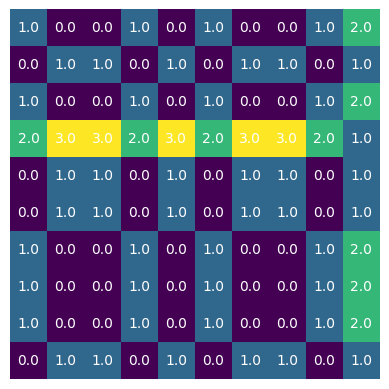

In [107]:
mat = cdist(ts_dict['Boston'].values[:10].reshape(-1,1), ts_dict['Birmingham'].values[:10].reshape(-1,1))

plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        text = plt.text(j, i, '%.1f' % mat[i, j], ha="center", va="center", color="w")
        
plt.show()

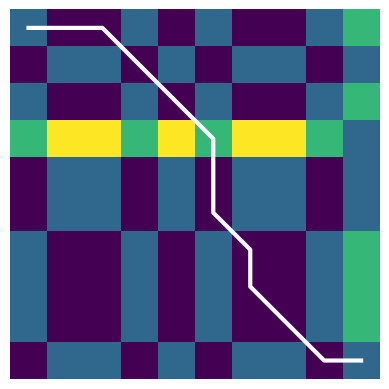

In [108]:
#we compute the distance (default euclidean)
mat = cdist(ts_dict['Boston'].values[:10].reshape(-1,1), ts_dict['Birmingham'].values[:10].reshape(-1,1))
plt.imshow(mat)
plt.axis("off")
plt.autoscale(False)
plt.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)
plt.show()

# CLUSTERING

In [125]:
#define a function to extract statistical features
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [126]:
#calculate the features for each time series
features_dict = {}
for city in ts_dict.keys():
    features_dict[city] = calculate_features(ts_dict[city])

features_dict['Boston']

{'avg': 1.1483253588516746,
 'std': 1.1076115815901881,
 'var': 1.2268034156727181,
 'med': 1.0,
 '10p': 0.0,
 '25p': 0.0,
 '50p': 1.0,
 '75p': 2.0,
 '90p': 3.0,
 'iqr': 2.0,
 'cov': 1.0367581722132537,
 'skw': 0.7825006209687683,
 'kur': -0.06503684772346441}

# ------------------------------------------------------------

In [222]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.generators import random_walks
import matplotlib.pyplot as plt
import numpy as np


 

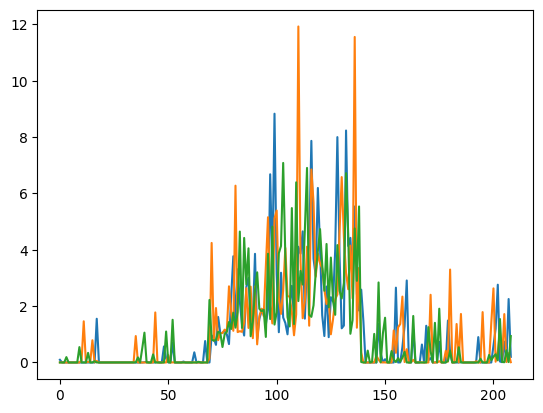

In [224]:

#create an array with the time series
X = np.array(list(ts_dict.values()))
X.shape




#kmeans clustering
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0).fit(X)


plt.plot(km.cluster_centers_.reshape(X.shape[1], 3))
plt.show()


In [225]:
km.inertia_

37.97754076090868

### 2. Feature-based clustering 


In [182]:
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [183]:
F = [list(calculate_features(x).values())[:-2] for x in X]


In [219]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(F)

KMeans(n_clusters=3, n_init=10)

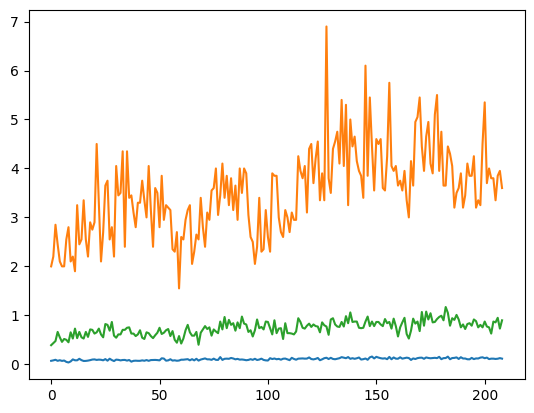

In [220]:
for i in range(3):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [221]:
kmeans.inertia_


1382.804059666098